# Hydrocarbon volumes calculator

The expression for _oil_ volumes in place:

$$ V = c \times GRV \times \phi \times NTG \times S_\mathrm{HC} \times \frac{1}{FVF} $$

where:

- c: conversion factor: `7758` from acre-ft to bbl (oil) or `43560` from acre-ft to ft3 (gas)
- V: hydrocarbon volumes
- GRV: Gross rock volume
- $\phi$: Porosity
- NTG: Net-to-gross
- $S_HC$: Hydrocarbon saturation (oil or gas)
- FVF: Formation volume factor


### Gross rock volume

Gross rock volume (GRV) can be expressed as:

$$GRV = A \times T \times G$$

where:

- A: Area
- T: Thickness
- G: Geometric correction factor

The [Geometric correction factor](https://subsurfwiki.org/wiki/Geometric_correction_factor) is applied to account for pinch out of the oil column at the edges of the prospect, it is a function of the thickness to closure height ratio as illustrated below:

<html>
    <img src="http://subsurfwiki.org/images/6/66/Geometric_correction_factor.png", width=600>
</html>

In [1]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [2]:
def calc_grv(thickness, height, area, top='slab', g=False):
    """Calculate GRV for given prospect
    Args:
        thickness [float]: average thickness of reservoir
        height [float]: height of hydrocarbon column
        area [float]: area of hydrocarbon prospect
        top: structure shape, one of `{'slab', 'round', 'flat'}`
        g [float]: geometric correction factor
    Returns:
        grv following `thickness * area * geometric_correction_factor`
    """
    if g:
        g = g
    else:
        ratio = thickness / height

        if top == 'round':
            g = -0.6 * ratio + 1
        elif top == 'flat':
            g = -0.3 * ratio + 1
        else:
            g = 1
    return thickness * area * g, g


def calc_hciip(GRV, phi=1, NTG=1, Sw=0, FVF=1, fluid='oil'):
    """Calculate Hydrocarbon initially in-place for a given prospect
    Args:
        GRV [float]: gross rock volume [acre-feet]
        phi [float]: porosity [fraction]
        NTG [float]: net-to-gross [fraction]
        Sw [float]: water saturation [fraction]
        FVF [float]: formation volume factor (Bo for oil or Bg for gas) [RES bbl/STB or RES ft3/SCF]
    """

    try:
        if fluid.lower() not in {'oil', 'gas'}:
            raise ValueError("`fluid` arg must be of `{'gas', 'oil'}`")
    except AttributeError:
        raise AttributeError("`fluid` arg must be of type `str`")

    if fluid == 'oil':
        constant = 7758 # conversion factor from acre-ft to bbl
    elif fluid == 'gas':
        constant = 43560 # conversion factor from acre-ft to ft3
   
    return (constant * GRV * phi * NTG * (1 - Sw)) / FVF

## Monte Carlo simulation of volumes

The two components of the Monte Carlo simulation are:
1. The equation to evaluate
2. The random variables for the input

Here the equation is `calc_hciip` and the variables are `{GRV, phi, NTG, Sw, FVF}`.

[Normal distribution applet](https://homepage.divms.uiowa.edu/~mbognar/applets/normal.html) and [Lognormal](https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html) to eyeball parameters.

First, define the distributions paramters:

In [3]:
grv_avg, grv_std = 8000, 800

phi_avg, phi_std = 0.3, 0.05
ntg_avg, ntg_std = 0.7, 0.05
sw_avg, sw_std = 0.2, 0.05
fvf_avg, fvf_std = 1.35, 0.08

num_samples = 500

Then sample from a normal distribution (to begin with) and calculate volumes:

In [4]:
grv = np.random.normal(grv_avg, grv_std, num_samples)
phi = np.random.normal(phi_avg, phi_std, num_samples)
ntg = np.random.normal(ntg_avg, ntg_std, num_samples)
sw = np.random.normal(sw_avg, sw_std, num_samples)
fvf = np.random.normal(fvf_avg, fvf_std, num_samples)

In [5]:
df = pd.DataFrame(index=range(num_samples), data={'grv': grv,'phi': phi,'ntg': ntg,'sw': sw,'fvf': fvf,})
df['hciip'] = calc_hciip(df.grv, df.phi, df.ntg, df.sw, df.fvf)
df.head()

,grv,phi,ntg,sw,fvf,hciip
0,8989.286432,0.297045,0.672859,0.264919,1.311780,7.810809e+06
1,8306.242853,0.297952,0.709292,0.178932,1.386662,8.063680e+06
2,6758.524150,0.252536,0.682872,0.195328,1.416896,5.135060e+06
3,7060.860026,0.227028,0.641070,0.181046,1.411700,4.624986e+06
4,8926.458233,0.225500,0.624711,0.162033,1.340299,6.099294e+06


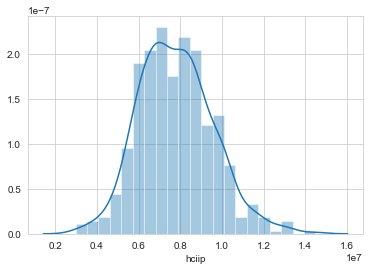

In [6]:
sns.distplot(df.hciip)

## Monte Carlo Experiment

Putting it all together and plotting the results

1. Define the property parameters and distributions:

In [7]:
# the grv could be a single value or min, ml, max from geophysics and petrophysics
grv_avg, grv_std = 8000, 800

# properties from petrophysics
phi_avg, phi_std = 0.3, 0.05
ntg_avg, ntg_std = 0.7, 0.05
sw_avg, sw_std = 0.2, 0.05

# properties from reservoir engineering
fvf_avg, fvf_std = 1.29, 0.08

# sample count for MC experiment
num_samples = 5000

# Choose random inputs for each variable
### NOTE THAT OTHER DISTIBUTIONS CAN BE SUBSTITUTED, SEE FOR EXAMPLE: https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions
grv = np.random.normal(grv_avg, grv_std, num_samples)
phi = np.random.normal(phi_avg, phi_std, num_samples)
ntg = np.random.normal(ntg_avg, ntg_std, num_samples)
sw = np.random.normal(sw_avg, sw_std, num_samples)
fvf = np.random.normal(fvf_avg, fvf_std, num_samples)

2. clean up the data if required and calculate the in-place volumes for `num_samples` times:

In [8]:
# set negative values to 0
for arr in [grv, phi, ntg, sw, fvf]:
    arr[arr < 0] = 0
# set values over 1 to 1
for arr in [phi, ntg, sw]:
    arr[arr > 1] = 1

# Build the dataframe based on the inputs and num_samples
df = pd.DataFrame(index=range(num_samples), data={'grv': grv,'phi': phi,'ntg': ntg,'sw': sw,'fvf': fvf,})

# calculate HCIIPs based on inputs
df['hciip'] = calc_hciip(df.grv, df.phi, df.ntg, df.sw, df.fvf)

In [9]:
#sns.pairplot(df.iloc[::100], vars=['grv', 'phi', 'ntg', 'sw']) # make sure to downsample with `.iloc` before plotting

In [10]:
df.describe(percentiles=[.1,.5,.9]).style.format('{:,.3f}')

,grv,phi,ntg,sw,fvf,hciip
count,"5,000.000","5,000.000","5,000.000","5,000.000","5,000.000","5,000.000"
mean,"8,009.278",0.301,0.701,0.200,1.290,"8,161,799.694"
std,793.478,0.049,0.050,0.049,0.080,"1,836,014.531"
min,"5,313.685",0.118,0.525,0.014,0.982,"2,814,639.960"
10%,"6,990.493",0.238,0.637,0.138,1.186,"5,939,708.142"
50%,"8,020.547",0.301,0.701,0.200,1.290,"8,034,138.660"
90%,"9,020.320",0.364,0.767,0.264,1.394,"10,590,656.137"
max,"10,769.774",0.468,0.906,0.390,1.612,"15,252,673.103"


In [11]:
# reverse p90, p50, p10 to match oil-field convention
p90, p50, p10 = df.describe(percentiles=[.1,.5,.9]).loc[['10%', '50%', '90%'], 'hciip']

3. Plot the results:

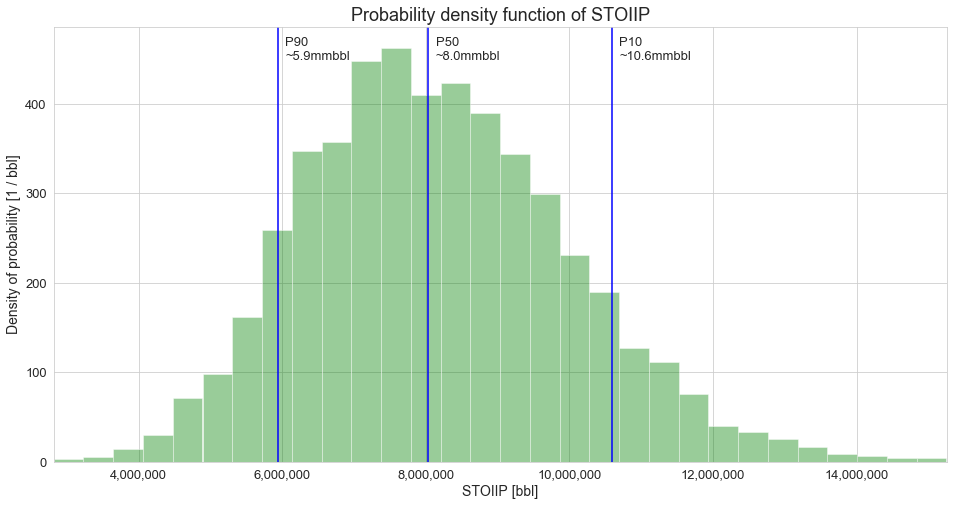

In [12]:
fig, ax = plt.subplots(figsize=(16,8))

n, *_ = ax.hist(df.hciip, bins=30, alpha=0.4, color='green')
n_len = (len(str(int(n.max()))))
y_max = round(n.max(), -(n_len-1))

title = 'Probability density function of STOIIP'
ax.set_title(title, fontsize=18)

minvol, maxvol = df.hciip.describe().loc[['min', 'max']]

for name, prob in {'P90': p90, 'P50': p50, 'P10': p10}.items():
    prob_approx = '\n~'+str(round(prob, -5)/1e6)+'mmbbl'
    plt.axvline(prob, c='b', linewidth=1.5)
    ax.text(prob + 100000, y_max - y_max*.1, name + prob_approx, fontdict={'fontsize': 13})

ax.set_xlim(minvol, maxvol)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel('STOIIP [bbl]', fontsize=14)
ax.set_ylabel('Density of probability [1 / bbl]', fontsize=14)

plt.show()

## Tornado experiment

Each variable is set to its min and max while the other ones have their default average values to calculate STOIIP. The relative impact on STOIIP is then measured.

In [13]:
grv_avg, grv_std = 8000, 800
phi_avg, phi_std = 0.3, 0.05
ntg_avg, ntg_std = 0.7, 0.05
sw_avg, sw_std = 0.2, 0.05
fvf_avg, fvf_std = 1.29, 0.08

grv = np.random.normal(grv_avg, grv_std, num_samples)
phi = np.random.normal(phi_avg, phi_std, num_samples)
ntg = np.random.normal(ntg_avg, ntg_std, num_samples)
sw = np.random.normal(sw_avg, sw_std, num_samples)
fvf = np.random.normal(fvf_avg, fvf_std, num_samples)

for arr in [grv, phi, ntg, sw, fvf]:
    arr[arr < 0] = 0
for arr in [phi, ntg, sw]:
    arr[arr > 1] = 1

grv_min, grv_max = grv.min(), grv.max()
phi_min, phi_max = phi.min(), phi.max()
ntg_min, ntg_max = ntg.min(), ntg.max()
sw_min, sw_max = sw.min(), sw.max()
fvf_min, fvf_max = fvf.min(), fvf.max()

In [14]:
def calc_impact(args):
    """calculate positive or negative impact on mean
    Args:
        list of args, [str]: one of `{'args_mi', 'args_ma'}` where
        args_mi is: `[grv_min, phi_min, ntg_min, sw_max, fvf_max]`
        args_ma is: `[grv_max, phi_max, ntg_max, sw_min, fvf_min]`
    Returns:
        np.array of impact on mean, either negs or posvs
    """
    if (args != 'args_mi') and (args != 'args_ma'):
        raise ValueError("args must be one of `{'args_mi', 'args_ma'}`")
    
    args_av = [grv_avg, phi_avg, ntg_avg, sw_avg, fvf_avg] 
    args_mi = [grv_min, phi_min, ntg_min, sw_max, fvf_max]
    args_ma = [grv_max, phi_max, ntg_max, sw_min, fvf_min]
    
    if args == 'args_mi':
        args = args_mi
    else:
        args = args_ma
        
    vals = []
    stoiip_avg = calc_hciip(*args_av)
    for idx, args in enumerate(args):
        calc_args = args_av.copy()
        calc_args.insert(idx, args)
        calc_args.pop(idx+1)
        vals.append(np.abs(100 - calc_hciip(*calc_args) * 100 / stoiip_avg))
        calc_args = args_av.copy()
        
    return vals

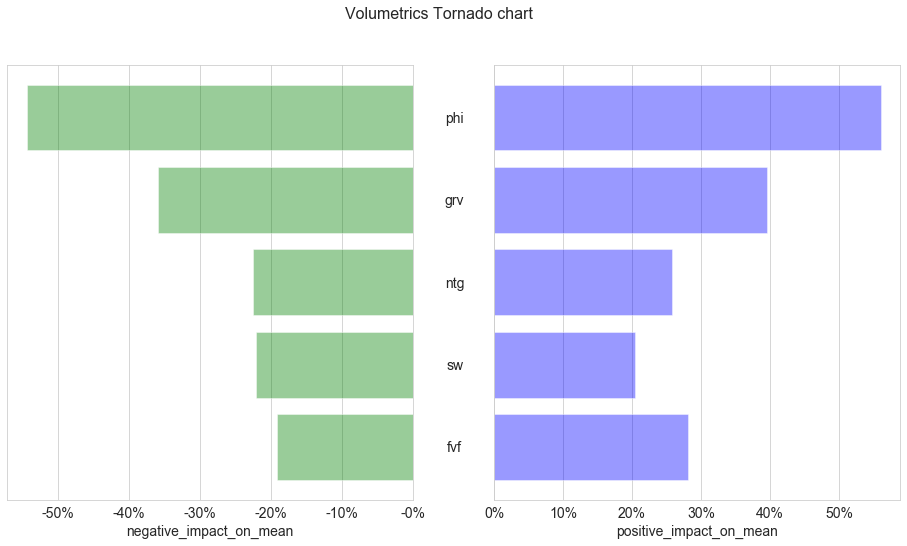

In [15]:
props = ['grv', 'phi', 'ntg', 'sw', 'fvf']
num_props = len(props)

negs = np.array(calc_impact('args_mi'))
posvs = np.array(calc_impact('args_ma'))
results = np.array([props, negs, posvs])

props = results.T[results.T[:,1].argsort()][:,0]
negative_impact_on_mean = results.T[results.T[:,1].argsort()][:,1].astype(float)
positive_impact_on_mean = results.T[results.T[:,1].argsort()][:,2].astype(float)

pos = np.arange(num_props) + .5 # bars centered on the y axis

fig, axs = plt.subplots(figsize=(16, 8), ncols=2)

ax = axs[0]
ax.barh(pos, negative_impact_on_mean, align='center', facecolor='green', alpha=0.4)
ax.set_yticks([])
ax.set_xlabel('negative_impact_on_mean', fontsize=14)
ax.invert_xaxis()
ax.grid(axis='y')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.xaxis.set_major_formatter(StrMethodFormatter('-{x:,.0f}%'))

ax = axs[1]
ax.barh(pos, positive_impact_on_mean, align='center', facecolor='blue', alpha=0.4)
ax.set_yticks(pos)
ax.set_yticklabels(props, ha='center', x=-0.08, fontsize=16)
ax.set_xlabel('positive_impact_on_mean', fontsize=14)
ax.grid(axis='y')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}%'))

plt.suptitle('Volumetrics Tornado chart', fontsize=16)

plt.show()